# Visualizations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict, Counter

plt.style.use('dark_background')

In [2]:
features_df = pd.read_parquet('ProcessedData/features.parquet.gzip')
metrics_df = pd.read_parquet('ProcessedData/metrics.parquet.gzip')
metadata_df = pd.read_parquet('ProcessedData/metadata.parquet.gzip')

In [3]:
data = features_df.join(metrics_df).join(metadata_df)

In [4]:
loglikes_by_section = defaultdict(list)

for _, row in data.iterrows():
    if row['metadata_section'] is not None:
        loglikes_by_section[row['metadata_section']].append(row['log_likes'])

In [5]:
top_sections = sorted([(k, np.median(np.array(v)), len(v)) for k, v in loglikes_by_section.items() if len(v) > 50], key = lambda x: -x[1])
top_sections, _, _ = zip(*top_sections)

In [6]:
filtered_data = data[data['metadata_section'].isin(top_sections)].copy()

In [7]:
filtered_data['like_bins'] = pd.cut(np.round(10**filtered_data['log_likes'] - 1), [0,100,200,500,1000,200000])

In [8]:
likeBinsGroup = filtered_data.groupby(['metadata_section', 'like_bins']).size().unstack()
likeBinsProp = likeBinsGroup.div(likeBinsGroup.sum(axis = 1), axis = 0)
likeBinsProp = likeBinsProp.loc[top_sections[::-1], :]

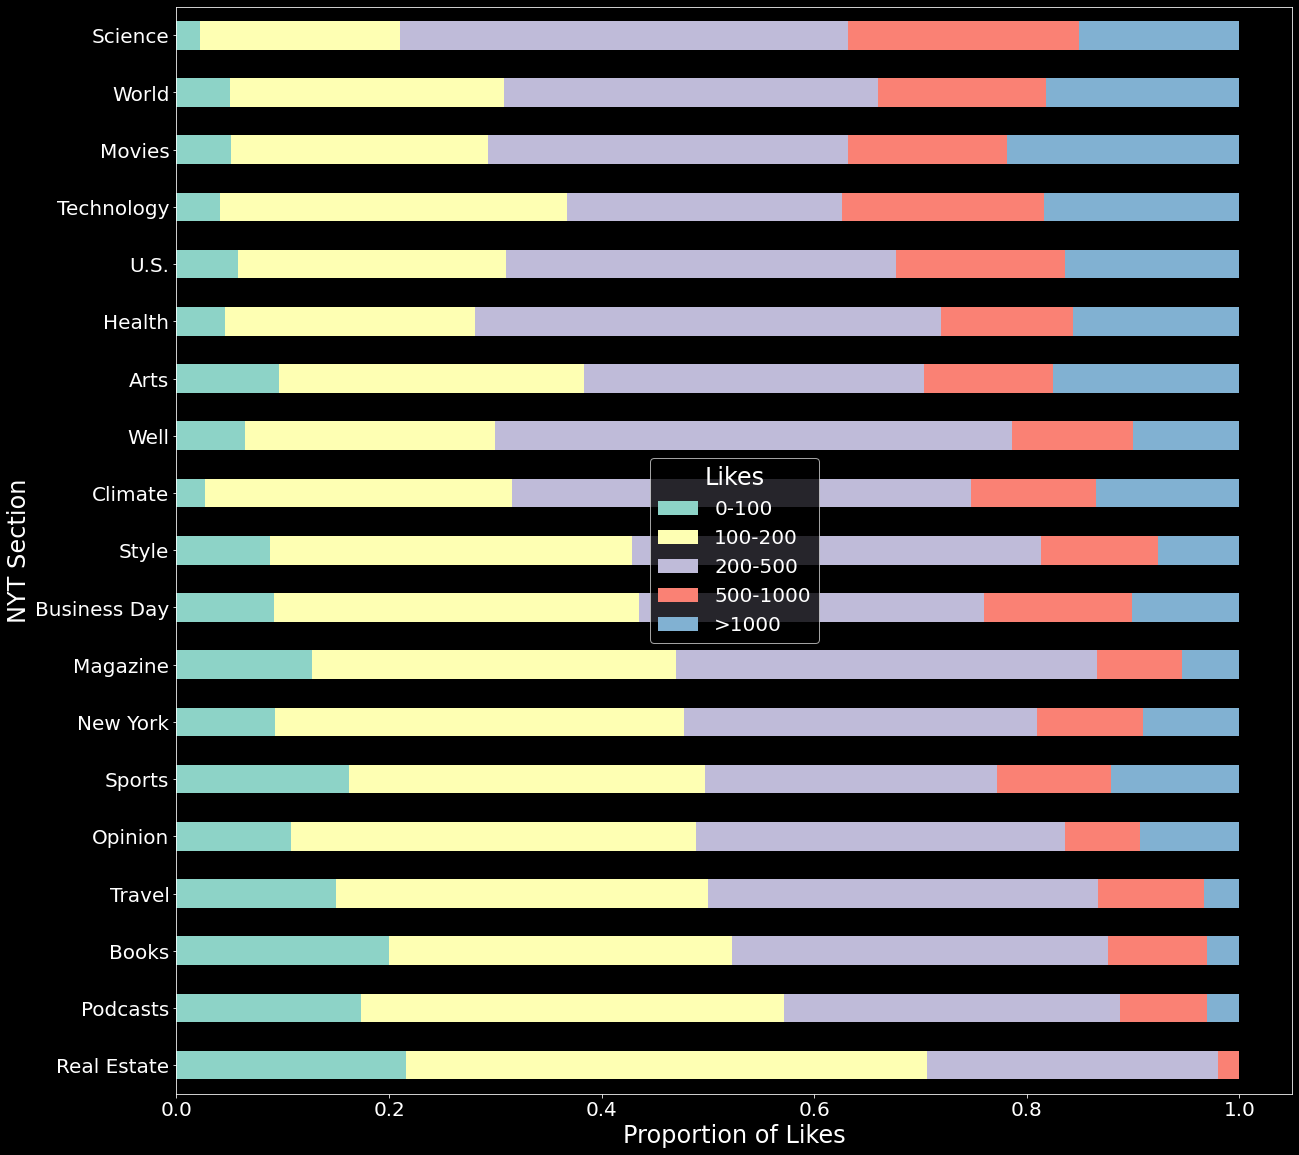

In [9]:
fig = plt.figure(figsize = (20, 20))
ax = fig.subplots(1)
likeBinsProp.plot(kind = 'barh', stacked = True, ax = ax)
ax.set_xlabel('Proportion of Likes', fontsize = 24)
ax.set_ylabel('NYT Section', fontsize = 24)
ax.tick_params(axis="y", labelsize=20)
ax.tick_params(axis="x", labelsize=20)
ax.legend(['0-100', '100-200', '200-500', '500-1000', '>1000'], title = 'Likes', title_fontsize = 24, fontsize = 20);

In [10]:
loglikes_by_keyword = defaultdict(list)

for _, row in data.iterrows():
    if row['metadata_keywords'] is not None:
        keywords = row['metadata_keywords'].split('|')
        for word in keywords:
            loglikes_by_keyword[word].append(row['log_likes'])

In [11]:
# sorted([(k, np.median(np.array(v)), len(v)) for k, v in loglikes_by_keyword.items()], key = lambda x: -x[2])

In [12]:
loglikes_by_topic = defaultdict(list)
keywords_by_topic = defaultdict(Counter)

TOPIC_THRESHOLD = 0.2

for _, row in data.iterrows():
    for topic_index in range(130):
        topic_name = f'topic_{topic_index:03}'
        if row[topic_name] > TOPIC_THRESHOLD:
            loglikes_by_topic[topic_name].append(row['log_likes'])
            if row['metadata_keywords'] is not None:
                keywords = row['metadata_keywords'].split('|')
                keywords_by_topic[topic_name].update(keywords)

In [13]:
# sorted([(k, np.median(np.array(v)), len(v)) for k, v in loglikes_by_topic.items()], key = lambda x: -x[1])

In [14]:
# sorted([(k, v.most_common(5), len(loglikes_by_topic[k])) for k, v in keywords_by_topic.items()])

In [15]:
curated_topics = []

with open('ProcessedData/topic_keywords', 'rt') as f:
    for word in f:
        curated_topics.append(word.strip())

In [16]:
keyword_loglikes_df = pd.DataFrame([(k, loglike) for k, v in loglikes_by_keyword.items() for loglike in v], columns = ['keyword', 'log_likes'])
keyword_loglikes_df = keyword_loglikes_df[keyword_loglikes_df['keyword'].isin(curated_topics)]

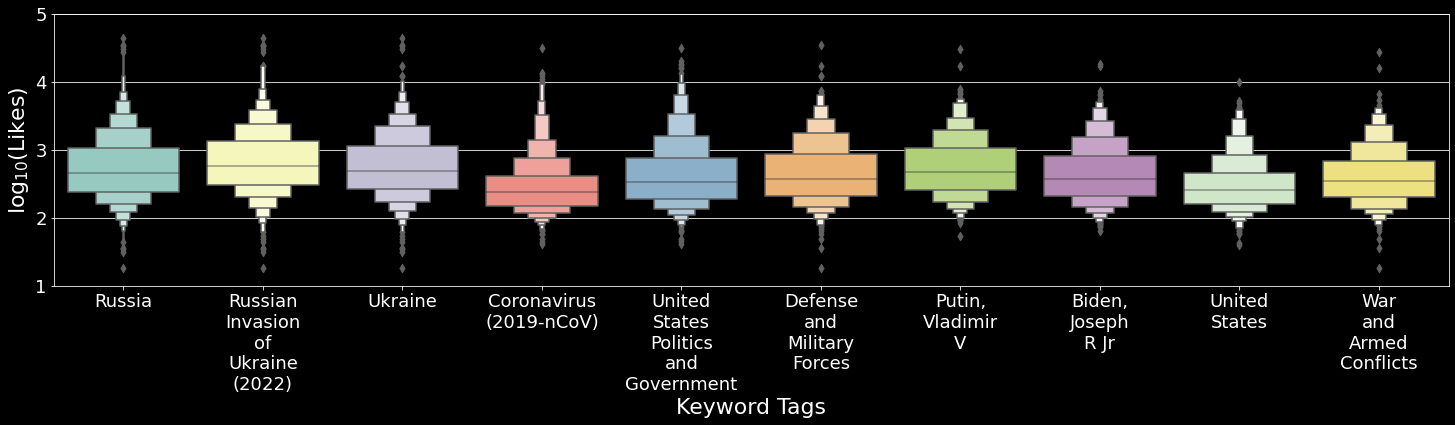

In [17]:
from matplotlib.ticker import MultipleLocator
import textwrap

order = curated_topics[:10]

fig, ax = plt.subplots(figsize = (25, 5))
ax.grid(zorder = 0)
ax.yaxis.set_major_locator(MultipleLocator(1))
boxen = sns.boxenplot(x = 'keyword', y = 'log_likes', data = keyword_loglikes_df, ax = ax, order = order)
ax.set_xticklabels([textwrap.fill(lab, 6, break_long_words = False) for lab in order])
plt.setp(boxen.collections, zorder = 10);
plt.setp(boxen.lines, zorder=11);
ax.set_ylim(1,5)
ax.set_xlabel('Keyword Tags', fontsize = 22)
ax.set_ylabel(r'$\log_{10}({\rm Likes})$', fontsize = 22)
ax.tick_params(axis="y", labelsize=18)
ax.tick_params(axis="x", labelsize=18)

In [18]:
# keyword_loglikes_df.to_parquet('ProcessedData/keyword_distributions.parquet.gzip', compression = 'gzip')